## How Autoencoders work - Understanding the math and implementation
https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

# Introduction

## Autoencoders란
오토 인코더는 출력이 입력과 동일한 특수한 유형의 신경망 아키텍처입니다. 오토 인코더는 입력 데이터의 극히 낮은 수준의 표현을 학습하기 위해 비지도 방식으로 학습됩니다. 그런 다음 이러한 낮은 수준의 피처는 실제 데이터를 투영하기 위해 다시 변형됩니다. 오토 인코더는 네트워크에서 입력을 예측하도록 요청되는 회귀 작업입니다(즉, ID 함수를 모델링). 이 네트워크들은 중간에 몇 개의 뉴런에 대한 병목현상이 심해서, 디코더가 원래의 입력을 재현하기 위해 사용할 수 있는 저차원 코드로 입력을 압축하는 효과적인 표현을 만들도록 강요합니다.

일반적인 오토 인코더 아키텍처는 다음과 같은 세 가지 주요 구성 요소로 이루어집니다.
- 인코딩 아키텍처: 인코더 아키텍처는 노드 수가 감소하고 궁극적으로 잠재 뷰 표현으로 감소하는 일련의 계층으로 구성됩니다.
- 잠재 뷰 표현: 잠재 뷰는 입력이 감소되고 정보가 보존되는 가장 낮은 수준의 공간을 나타냅니다.
- 디코딩 아키텍처: 디코딩 아키텍처는 인코딩 아키텍처의 미러 이미지이지만, 모든 계층의 노드 수가 증가하고 궁극적으로 유사한(거의) 입력을 출력합니다.

고도로 미세하게 튜닝된 오토 인코더 모델은 첫 번째 계층에서 전달된 동일한 입력을 재구성할 수 있어야 합니다. 이 커널에서 오토 인코더의 작업과 오토 인코더의 구현 과정을 안내하겠습니다. 오토 인코더는 이미지 데이터와 함께 널리 사용되며, 그 사용 사례 중 일부는 다음과 같습니다.

- 차원 축소
- 이미지 압축
- 이미지 노이즈 제거
- 이미지 생성
- 피쳐 추출

## How Autoencoders work
오토 인코더 뒤에 숨겨진 수학에 대해 알아보겠습니다. 자동오토 인코더의 주된 아이디어는 높은 수준의 치수 데이터를 낮은 수준으로 재현하는 것입니다. 예를 들어 인코딩 프로세스를 이해하도록 해보겠습니다. 데이터 표현 공간(데이터를 나타내는 데 사용되는 N차원 공간)과 x1 및 x2의 두 변수로 표시되는 데이터 점을 고려합니다. 데이터 매니폴드는 실제 데이터가 있는 데이터 표현 공간 내부의 공간입니다.

In [23]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import numpy as np
init_notebook_mode(connected=True)

# generate random data
N = 50
random_x = np.linspace(2, 10, N)
random_y1 = np.linspace(2, 10, N)
random_y2 = np.linspace(2, 10, N)

trace1 = go.Scatter(x=random_x, y=random_y1, mode='markers', name='Actual Data')
trace2 = go.Scatter(x=random_x, y=random_y2, mode='lines', name='Model')
layout = go.Layout(title='2D Datat Representation Space', xaxis=dict(title='x2', range=(0, 12)),
                  yaxis=dict(title='x1', range=(0, 12)), height=400,
                  annotations=[dict(x=5, y=5, xref='x', yref='y', text='This 1D line is the Data Manifold (where data resides)', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363', ax=-120, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8)])
figure = go.Figure(data=[trace1], layout=layout)
iplot(figure)

이 데이터를 나타내기 위해 현재 X와 Y의 2차원을 사용하고 있습니다. 그러나 이 공간의 치수를 더 낮은 치수(1D)로 줄일 수 있습니다. 다음을 정의할 수 있습니다.

- 선의 기준점: A입니다.
- L을 수평축으로 기울입니다.

B와 같은 다른 점은 A의 거리 "d"와 각도 L로 나타낼 수 있습니다.

In [24]:
random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="x1", range=(0,12)), yaxis=dict(title="x2", range=(0,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="2D Data Repersentation Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)


#

random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="u1", range=(1.5,12)), yaxis=dict(title="u2", range=(1.5,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="Latent Distance View Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)

하지만 여기서 중요한 질문은 어떤 논리나 규칙, 지점 B가 A와 각도 L로 표현될 수 있느냐 하는 것입니다. 또는 다른 용어로 B, A, L의 방정식은 무엇입니까? 답은 간단합니다. 고정된 방정식은 없지만 비지도 학습 과정에 의해 가능한 가장 좋은 방정식이 얻어집니다. 간단히 말해서, 학습 과정은 A와 L의 형태로 B를 변환하는 규칙/방정식으로 정의될 수 있습니다. 오토 인코더의 관점에서 이 프로세스를 이해하겠습니다.

숨겨진 레이어가 없는 자동 인코더를 생각해 보십시오. 입력 x1 및 x2는 낮은 표현으로 인코딩되며, 그러면 x1 및 x2에 추가로 투영됩니다.

__Step1: 잠재 뷰 공간의 포인트 재현__

데이터 표현 공간에서 점 A와 B의 좌표가 다음과 같은 경우:

- 지점 A: (x1A, x2A)
- 지점 B: (x1B, x2B)

잠재 뷰 공간에 있는 좌표는 다음과 같습니다.

- (x1A, x2A) ---> (0, 0)
- (x1B, x2B) ---> (u1B, u2B)

- 지점 A: (0, 0)
- 지점 B: (u1B, u2B)

여기서 u1B와 u2B는 점과 기준점 사이의 거리 형태로 표시될 수 있습니다.

u1B = x1B - x1A

u2B = x2B - x2A

__Step2: 거리 d 및 각도 L로 점을 나타냅니다__

이제, u1B와 u2B는 거리 d와 각도 L의 조합으로 표현될 수 있습니다. 이것을 각도 L, 수평 축으로 돌리면 L은 0.즉, 0이 됩니다.

__=> (d, L)__

__=> (d, 0)(회전 후)__


이것은 인코딩 프로세스의 출력이며 저차원으로 데이터를 나타냅니다. 만약 우리가 모든 계층의 무게와 편향을 가진 신경망의 기본 방정식을 기억한다면, 그러면,

__=> (d, 0) = W.(u1B, u2B)__

==> 인코딩

여기서 W는 은닉층의 가중치 매트릭스입니다. 그 때문에, 우리는 디코딩 프로세스가 인코딩 프로세스의 미러 이미지라는 것을 알고 있습니다.

__=> (u1B, u2B) = Inverse(W).(d,0)__

==> 디코딩

축소된 데이터 형태(x1, x2)는 인코딩 아키텍처에서 얻은 잠재 뷰 공간에 (d, 0) 있습니다. 마찬가지로, 디코딩 아키텍처는 이 표현을 원래 형태(u1B, u2B)로 다시 변환한 다음(x1, x2)로 변환합니다. 중요한 점은 규칙 / 학습 함수 / 인코딩-디코딩 방정식은 데이터 유형에 따라 다르다는 것입니다. 예를 들어, 2차원 공간의 다음 데이터를 고려하십시오.

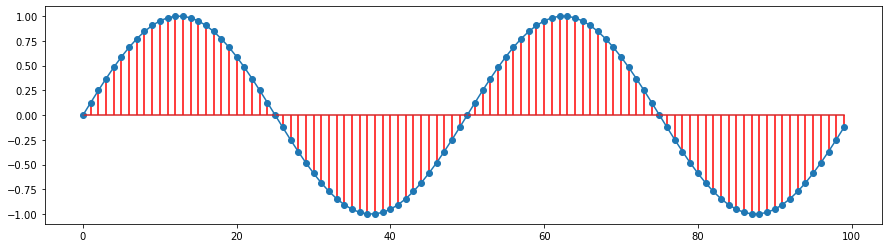

In [25]:
import matplotlib.pyplot as plt
import numpy as np
fs = 100 # sample rate
f = 2 # the frequency of the signal
x = np.arange(fs) # the points on the x axis for plotting
y = [np.sin(2*np.pi*f*(i/fs)) for i in x]

%matplotlib inline
plt.figure(figsize=(15, 4))
plt.stem(x,y,'r')
plt.plot(x,y)

이러한 유형의 데이터에서는 정보를 잃지 않고 단일 차원으로 데이터 투영을 얻는 것이 핵심 문제입니다. 이러한 유형의 데이터가 잠재 공간에 투사되면 많은 정보가 손실되고 이를 원래 모양으로 변형하여 투사하는 것은 거의 불가능합니다. 시프트와 회전이 아무리 많이 적용되더라도 원본 데이터는 복구할 수 없습니다.

그렇다면 신경망은 이 문제를 어떻게 해결할까요? 목적은 매니폴드 공간에서 심층 신경망은 선형 데이터 폴드 뷰를 얻기 위해 공간을 구부릴 수 있는 특성을 가지고 있다는 것입니다. 자동 인코더 아키텍처는 잠재 뷰 공간에서 낮은 수준의 표현을 학습할 수 있도록 이 속성을 히든 레이어에 적용합니다.

먼저 이미지에서 기능을 학습한 다음 출력과 동일한 이미지를 투사하는 케어를 사용하여 자동 인코더를 구현합니다.

# Implementation

## UseCase1 : Image Reconstruction

In [26]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

### Dataset Prepration

In [27]:
train = pd.read_csv('./input/fashion-mnist_train.csv')
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

# normalize and reshape the predictors
train_x = train_x / 255

# create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

# reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

### Create Autoencoder architecture
이 섹션에서는 오토 인코더 아키텍처를 생성하겠습니다. 인코딩 부분은 2000, 1200 및 500개의 노드가 있는 세 개의 계층으로 구성됩니다. 인코딩 아키텍처는 10개의 노드로 구성된 잠재 뷰 공간에 연결되며, 이후 500, 1200 및 2000개의 노드로 디코딩 아키텍처에 연결됩니다. 최종 계층은 입력 계층과 같은 정확한 노드 수로 구성됩니다.

In [28]:
# input layer
input_layer = Input(shape=(784,))

# encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

# latent view
latent_view = Dense(10, activation='sigmoid')(encode_layer3)

# decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

# output layer
output_layer = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [29]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_11 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              5010

In [30]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 111us/step - loss: 0.0974 - val_loss: 0.0703
Epoch 2/20
48000/48000 [==============================] - 1s 25us/step - loss: 0.0639 - val_loss: 0.0560
Epoch 3/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.0491 - val_loss: 0.0435
Epoch 4/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.0405 - val_loss: 0.0385
Epoch 5/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.0372 - val_loss: 0.0364
Epoch 6/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.0345 - val_loss: 0.0353
Epoch 7/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.0314 - val_loss: 0.0300
Epoch 8/20
48000/48000 [==============================] - 1s 22us/step - loss: 0.0287 - val_loss: 0.0288
Epoch 9/20
48000/48000 [==============================] - 1s 22us/step - loss: 0.0269 - val_loss: 0.0260
Epoc

In [31]:
preds = model.predict(val_x)

#### Inputs: Actual Images

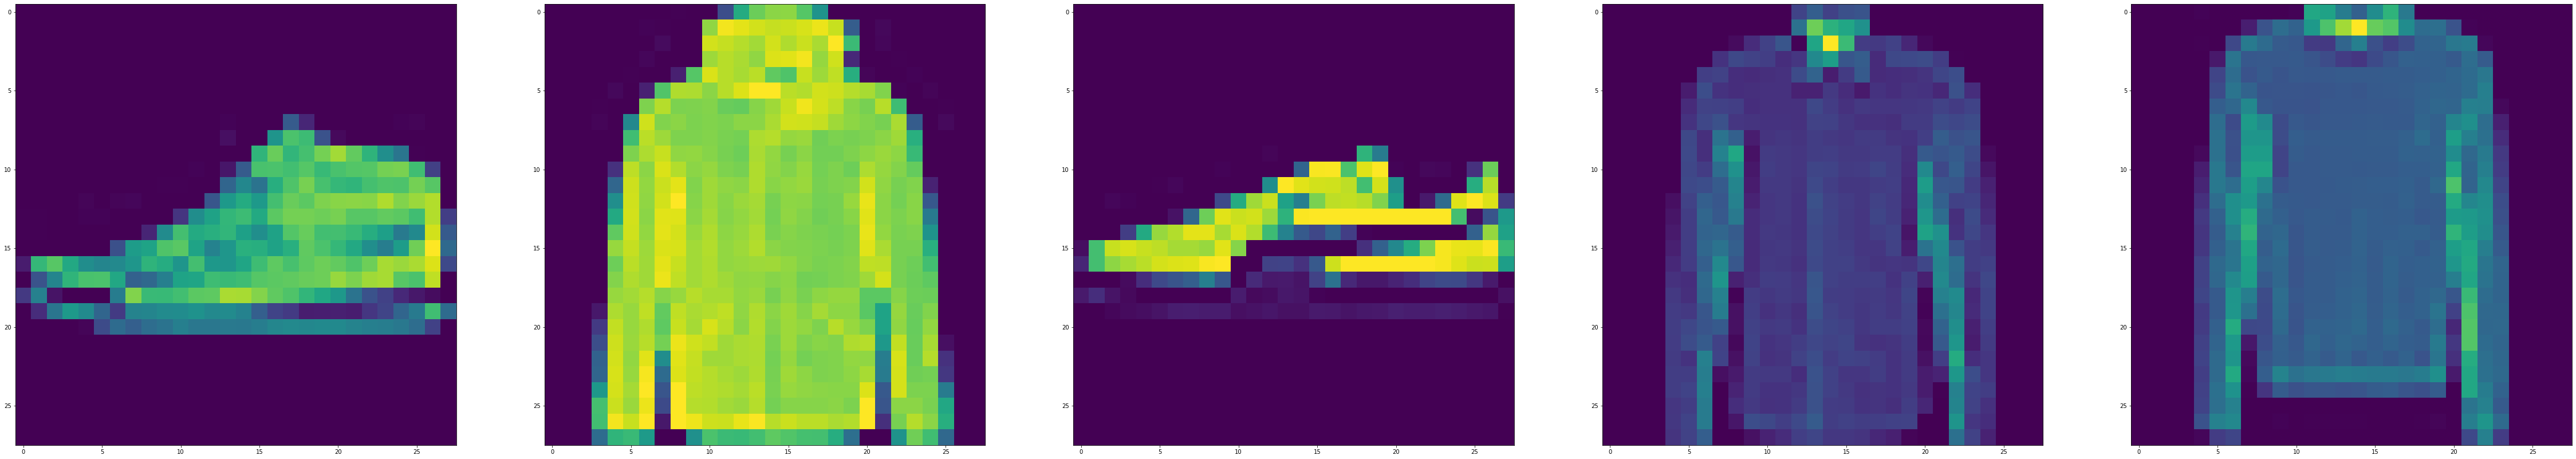

In [32]:
from PIL import Image
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

#### Predicted: Autoencoder Output

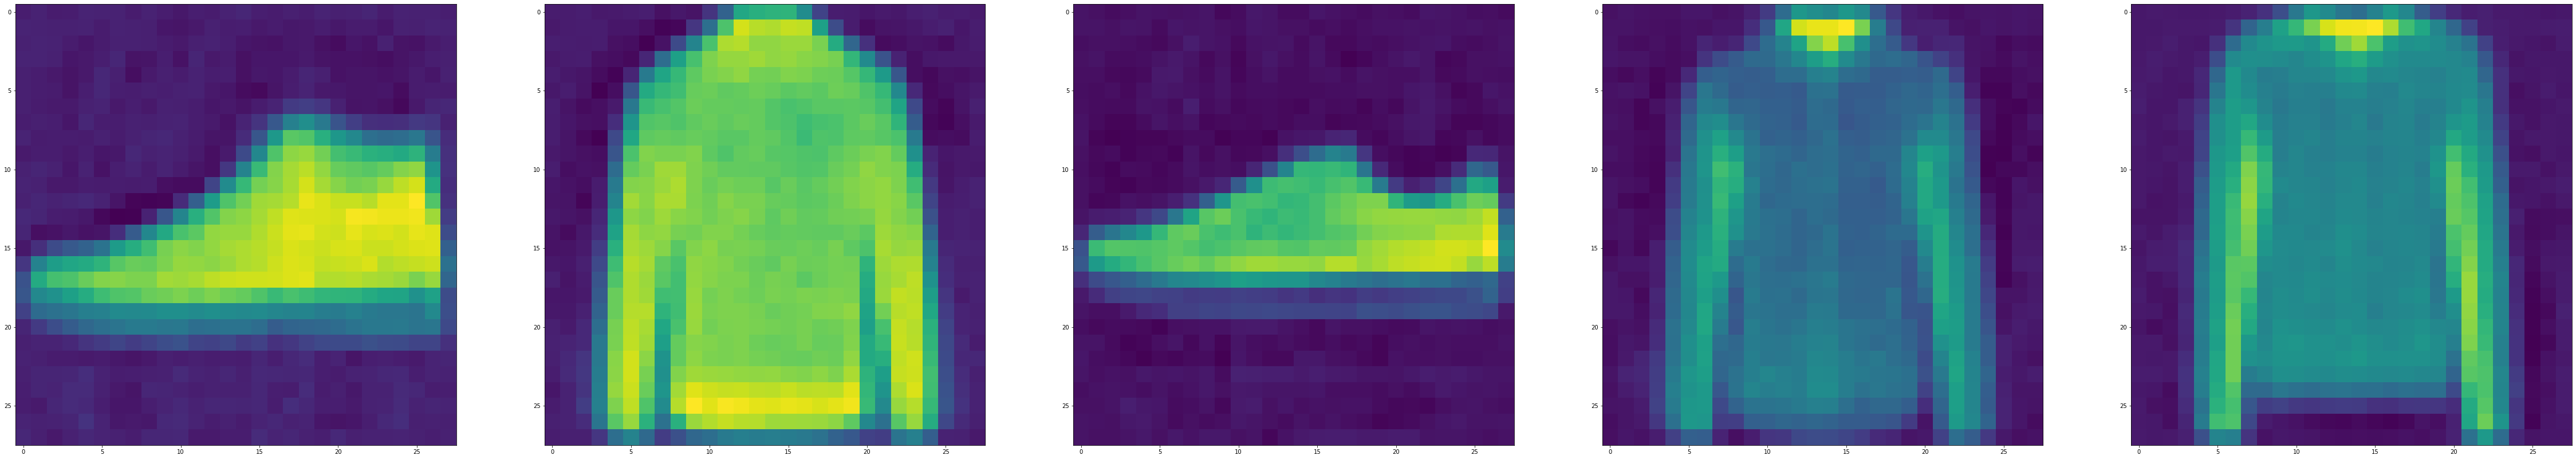

In [33]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

그래서 우리는 20개의 에포크로 훈련된 오토 인코더가 입력 이미지를 매우 잘 재구성할 수 있다는 것을 알 수 있습니다. 자동 인코더의 다른 사용 사례 - 이미지 노이즈 제거 또는 이미지 노이즈 제거에 대해 살펴보겠습니다.

## UseCase 2 - Image Denoising
오토 인코더는 매우 유용합니다. 오토 인코더의 다른 응용 프로그램인 이미지 노이즈 제거에 대해 살펴보겠습니다. 입력 이미지에 데이터에 노이즈가 포함되어 있는 경우 오토 인코더를 사용하여 해당 이미지를 제거할 수 있습니다. 실제로 보겠습니다. 먼저 이미지 픽셀을 포함하는 train_x 및 val_x 데이터를 준비합니다.

In [34]:
# recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

# normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

이 오토 인코더 네트워크에서는 컨볼루션 네트워크가 이미지 입력과 정말 잘 작동하기 때문에 컨볼루션 레이어를 추가할 것입니다. 이미지 데이터에 컨볼루션을 적용하기 위해 28 * 28 매트릭스 형식으로 입력을 재구성합니다.

In [35]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Noisy Images
이미지에 노이즈를 의도적으로 도입할 수 있습니다. 예를 들어 다음과 같습니다.

- 소금과 후추 노이즈
- 가우스 노이즈
- 주기적 노이즈
- 반점 노이즈
임펄스 노이즈라고도 하는 데이터에 소금과 후추 노이즈를 도입해 보겠습니다. 이 노이즈는 이미지 신호에 급격한 장애 발생을 일으킵니다. 드물게 발생하는 흰색 및 검은색 픽셀입니다.

In [36]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

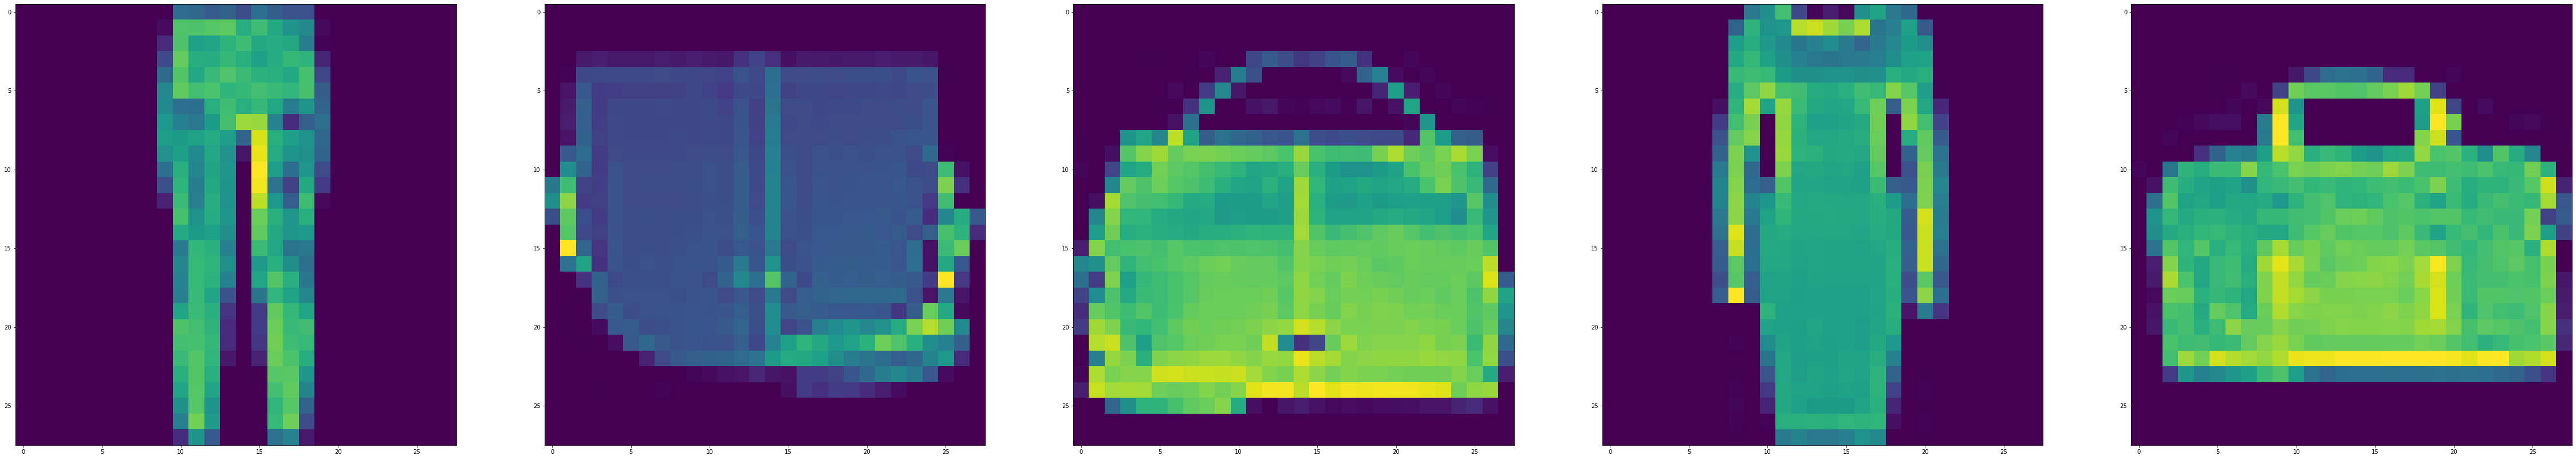

In [37]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5, 10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

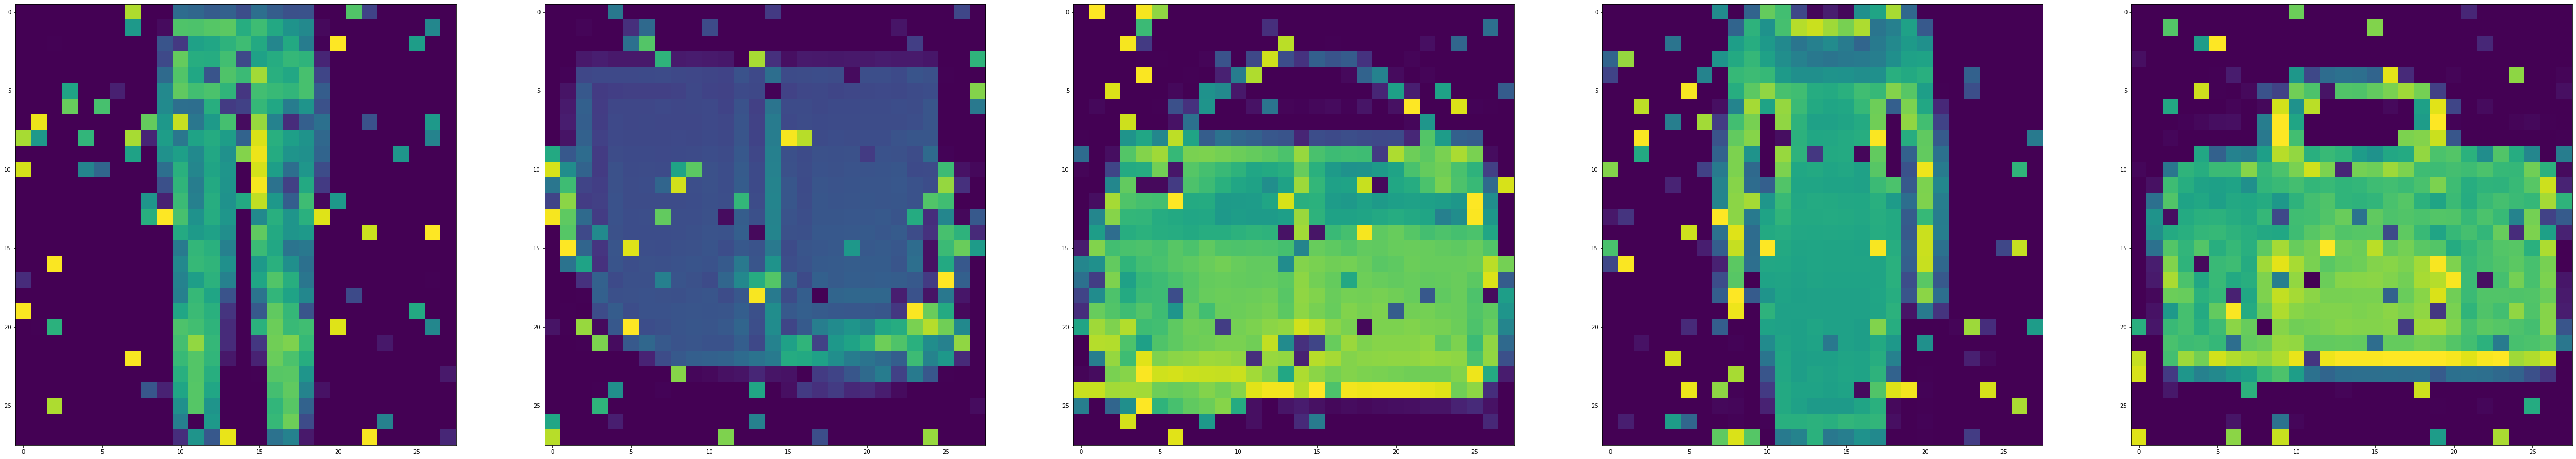

In [38]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5, 10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

이제 오토 인코더의 모델 아키텍처를 생성하겠습니다. 이 문제에 대해 어떤 유형의 네트워크를 생성해야 하는지 파악합니다.

__인코딩 아키텍처__:

인코딩 아키텍처는 3개의 컨볼루션 레이어와 3개의 맥스 풀링 레이어가 하나씩 쌓여서 구성됩니다. Relu는 컨볼루션 레이어에서 활성함수로 사용되며 패딩은 "동일"로 유지됩니다. 맥스 풀링 레이어의 역할은 이미지 치수를 축소하는 것입니다. 이 계층은 초기 표현의 겹치지 않는 하위 영역에 최대 필터를 적용합니다.

__아키텍처 디코딩__

아키텍처 디코딩에서도 마찬가지로, 컨볼루션 레이어는 인코딩 아키텍처와 동일한 차원(반대 방식)을 가지고 사용됩니다. 하지만 3개의 맥스 풀링 레이어 대신 3개의 업샘플링 레이어를 추가할 예정입니다. 다시 활성화 함수는 동일하며(relu), 컨볼루션 레이어의 패딩도 동일해집니다. 업샘플링 레이어의 역할은 입력 벡터의 치수를 더 높은 해상도/차원으로 업샘플링하는 것입니다. 맥스 풀링 작업은 되돌릴 수 없지만 각 풀링 영역 내에서 최대치의 위치를 기록하면 근사치를 얻을 수 있습니다. 업샘플링 레이어는 이 속성을 사용하여 낮은 치수 특징 공간에서 재구성을 투영합니다.

In [41]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view = MaxPool2D((2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [42]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)          0   

조기 중지 콜백으로 모델을 교육합니다. 더 나은 결과를 얻으려면 에포크 수를 더 높은 수로 늘립니다.

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 9s 193us/step - loss: 0.0834 - val_loss: 0.0490
Epoch 2/10
48000/48000 [==============================] - 4s 76us/step - loss: 0.0404 - val_loss: 0.0349
Epoch 3/10
48000/48000 [==============================] - 4s 76us/step - loss: 0.0321 - val_loss: 0.0297
Epoch 4/10
48000/48000 [==============================] - 4s 79us/step - loss: 0.0281 - val_loss: 0.0273
Epoch 5/10
48000/48000 [==============================] - 4s 78us/step - loss: 0.0259 - val_loss: 0.0250
Epoch 6/10
48000/48000 [==============================] - 4s 77us/step - loss: 0.0244 - val_loss: 0.0237
Epoch 7/10
48000/48000 [==============================] - 4s 77us/step - loss: 0.0233 - val_loss: 0.0227
Epoch 8/10
48000/48000 [==============================] - 4s 77us/step - loss: 0.0231 - val_loss: 0.0224
Epoch 9/10
48000/48000 [==============================] - 4s 76us/step - loss: 0.0220 - val_loss: 0.0214
Epoc

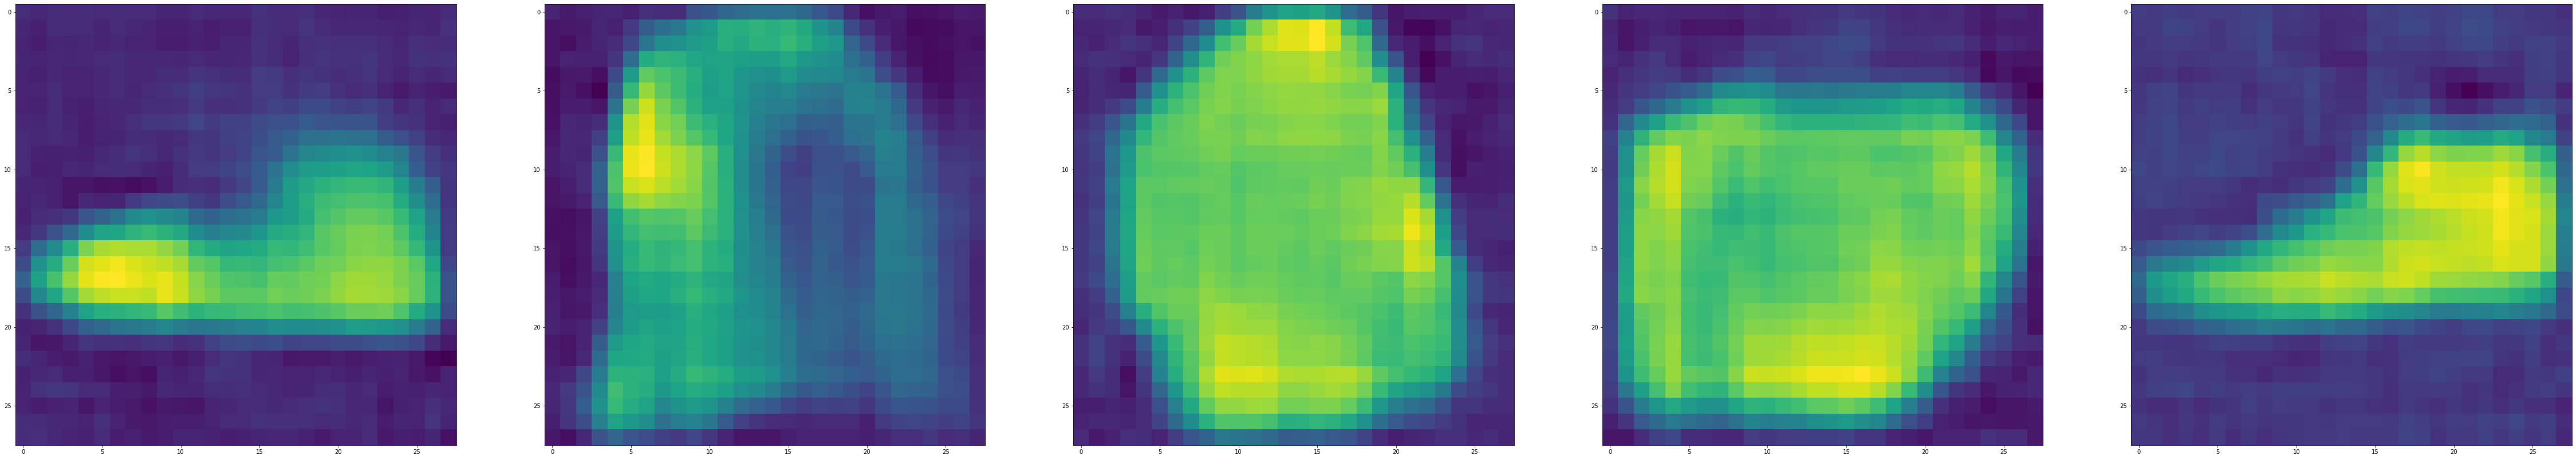

In [44]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5, 10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

이 구현에서, 더 나은 예측을 위해 500-1000범위의 에포크에 대해 네트워크를 훈련시킬 수 있습니다.

## UseCase 3: Sequence to Sequence Prediction using AutoEncoders
다음 사용 사례는 시퀀스 예측입니다. 앞의 예에서는 기본적으로 2차원 데이터인 이미지를 입력하고, 이 예에서는 시퀀스 데이터를 1차원 입력으로 입력합니다. 시퀀스 데이터의 예로는 시계열 데이터와 텍스트 데이터가 있습니다. 이 사용 사례는 기계 번역에 적용할 수 있습니다. 이미지 예제의 CNN과는 달리, 이 사용 사례에서는 LSTM을 사용할 것입니다.

__오토 인코더 아키텍처__

자동 인코더 아키텍처입니다.
이 사용 사례의 아키텍처에는 소스 시퀀스를 인코딩하는 인코더가 포함되어 있으며, 두 번째에는 인코딩된 소스 시퀀스를 디코더라고 하는 대상 시퀀스로 디코딩하는 인코더가 포함됩니다. 먼저 이 아키텍처에서 사용될 LSTM의 내부 작업을 이해하겠습니다.

- LSTM(Long-Short-Term Memory)은 내부 게이트로 구성된 반복 신경망입니다.
- 다른 반복 신경망과 달리, 네트워크의 내부 게이트는 시간을 통한 역 전파(BPTT)를 사용하여 모델을 성공적으로 훈련시키고 사라지는 그레이디언트 문제를 피할 수 있도록 합니다.
- LSTM 계층의 LSTM 메모리 유닛 수를 정의할 수 있습니다. 레이어 내의 각 유닛 또는 셀은 종종 "c"로 약칭되는 내부 메모리/셀 상태를 가지며, 종종 "h"로 약칭되는 숨겨진 상태를 출력합니다.
- Keras를 사용하면 LSTM 계층의 출력 상태와 LSTM 계층의 현재 상태에 모두 액세스할 수 있습니다.

이제 LSTM 계층으로 구성된 시퀀스를 학습하고 생성하기 위한 자동 인코더 아키텍처를 생성하겠습니다. 두 가지 구성 요소가 있습니다.

- 시퀀스를 입력으로 사용하고 LSTM의 현재 상태를 출력으로 반환하는 인코더 아키텍처입니다.
- 시퀀스 및 인코더 LSTM 상태를 입력으로 사용하고 디코딩된 출력 시퀀스를 반환하는 디코더 아키텍처입니다.
- 우리는 LSTM의 숨겨진 상태와 메모리 상태를 저장하고 액세스하여 보이지 않는 데이터에 대한 예측을 생성하는 동시에 이를 사용할 수 있습니다.

먼저 고정된 길이의 랜덤 시퀀스를 포함하는 시퀀스 데이터 세트를 생성하겠습니다. 랜덤 시퀀스를 생성하는 기능을 만들 것입니다.

- X1은 난수를 포함하는 입력 시퀀스를 나타냅니다.
- X2는 시퀀스의 다른 요소를 재현하기 위해 시드로 사용되는 패딩 시퀀스를 나타냅니다.
- y는 목표 시퀀스 또는 실제 시퀀스를 나타냅니다.

In [45]:
def dataset_preparation(n_in, n_out, n_unique, n_samples):
    X1, X2, y = [], [], []
    for _ in range(n_samples):
        ## create random numbers sequence - input
        inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]
        
        ## create target sequence
        target = inp_seq[:n_out]
        
        ## create padded sequence / seed sequence
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]
        
        # convert the elements to categorical using keras api
        X1.append(to_categorical([inp_seq], num_classes=n_unique))
        X2.append(to_categorical([seed_seq], num_classes=n_unique))
        y.append(to_categorical([target_seq], num_classes=n_unique))
        
    # remove unnecessary dimension
    X1 = np.squeeze(np.array(X1), axis=1)
    X2 = np.squeeze(np.array(X2), axis=1)
    y = np.squeeze(np.array(y), axis=1)
    return X1, X2, y

samples = 100000
features = 51
inp_size= 6
out_size= 3

inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)
print('Shapes:', inputs.shape, seeds.shape, outputs.shape)
print('Here is first categorically encoded input sequence looks like')
inputs[0][0]

Shapes: (100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
Here is first categorically encoded input sequence looks like


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

다음으로, 케라스에서 우리 모델의 아키텍처를 만들어 보겠습니다.

In [47]:
def define_models(n_input, n_output):
    # define the encoder architecture
    # input: sequence
    # output: encoder states
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # define the encoder-decoder architecture
    # input: a seed sequence
    # output: decoder states, decoded output
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # define the decoder model
    # input: current states + encoded sequence
    # output: decoded sequence
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = define_models(features, features)

In [48]:
encoder_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, 51)          0         
_________________________________________________________________
lstm_3 (LSTM)                [(None, 128), (None, 128) 92160     
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


In [49]:
decoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 128),  92160       input_10[0][0]                   
                                                                 input_11[0][0]             

In [50]:
autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, 51)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 128), (None, 92160       input_9[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 128),  92160       input_10[0][0]                   
                                                                 lstm_3[0][1]               

이제 Adam 최적화 및 범주형 교차 엔트로치 손실 함수를 사용하여 오토 인코더 모델을 교육합니다.

In [51]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
autoencoder.fit([inputs, seeds], outputs, epochs=1)

Epoch 1/1
100000/100000 [==============================] - 25s 250us/step - loss: 0.6468 - acc: 0.7954


입력 시퀀스를 기준으로 시퀀스를 예측하는 함수를 쓰겠습니다.

In [52]:
def reverse_onehot(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

def predict_sequence(encoder, decoder, sequence):
    output = []
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1, 1, features)
    
    current_state = encoder.predict(sequence)
    for t in range(out_size):
        pred, h, c = decoder.predict([target_seq] + current_state)
        output.append(pred[0, 0, :])
        current_state = [h, c]
        target_seq = pred
    return np.array(output)

In [54]:
for k in range(5):
    X1, X2, y = dataset_preparation(inp_size, out_size, features, 1)
    target = predict_sequence(encoder_model, decoder_model, X1)
    print('\n Input Sequence=%s SeedSequence=%s, PredictedSequence=%s' % (reverse_onehot(X1[0]), reverse_onehot(y[0]), reverse_onehot(target)))


 Input Sequence=[10, 19, 37, 32, 42, 50] SeedSequence=[37, 19, 10], PredictedSequence=[37, 19, 10]

 Input Sequence=[5, 45, 16, 15, 37, 10] SeedSequence=[16, 45, 5], PredictedSequence=[16, 45, 5]

 Input Sequence=[40, 16, 33, 46, 20, 29] SeedSequence=[33, 16, 40], PredictedSequence=[33, 16, 40]

 Input Sequence=[19, 14, 39, 3, 2, 6] SeedSequence=[39, 14, 19], PredictedSequence=[39, 14, 19]

 Input Sequence=[45, 17, 34, 20, 28, 44] SeedSequence=[34, 17, 45], PredictedSequence=[34, 17, 45]
